# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1897 sha256=c02d49d10d1cbe3791c7593eb70889ac4d27ac690df9b7db84cd6f01cfae2182
  Stored in directory: /root/.cache/pip/wheels/0b/68/37/a457e156cfd6174ed28c9c8cb76f18eeb559b760d84c0a22eb
Successfully built pycrf
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 965 kB 4.2 MB/s 


##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

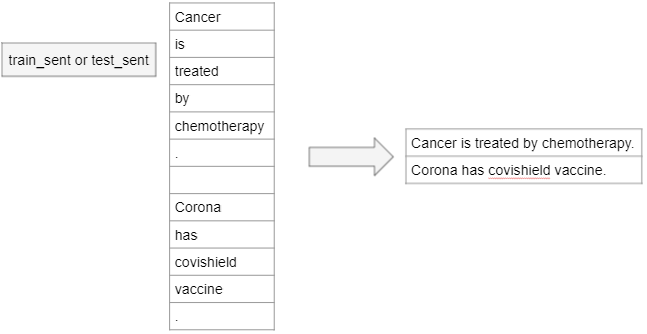

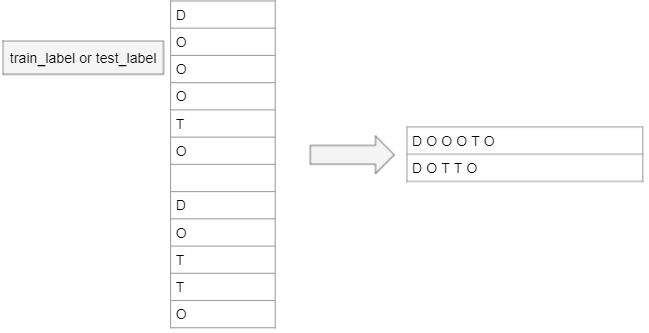

### Count the number of sentences in the processed train and test dataset 

### Count the number of lines of labels in the processed train and test dataset.

In [33]:
# Function to create sentence based on new line and count the sentence and labels 
def text_read(file_path,file):
  try:
    with open(file_path, 'r') as text:
      if text.mode  == 'r':
                content = text.readlines()
    sentence = []
    complete_sentence = ''
    for c in content:
      new_word = c.strip('\n')
      if new_word == '':
        sentence.append(complete_sentence.strip(' '))
        complete_sentence=''
      else:
         complete_sentence+=new_word+' '
    print(file+' Total values: ',len(sentence))
    print(file+' sample value:\n',sentence[100],'\n')
    return sentence
  except FileNotFoundError:
        print('Incorrect file path')


In [34]:
# Call function to Read all the train test file and display count and sample values.
train_sentences = text_read('train_sent', 'Train Sentence')
train_labels = text_read('train_label', 'Train Label')
test_sentences = text_read('test_sent', 'Test Sentence')
test_labels = text_read('test_label', 'Test Label') 

Train Sentence Total values:  2599
Train Sentence sample value:
 All women were expectantly managed without tocolytics until 37 weeks ' gestation unless they developed clinical chorioamnionitis , or nonreassuring fetal heart rate tracing or biophysical profile 

Train Label Total values:  2599
Train Label sample value:
 O O O O O O O O O O O O O O O O O O O O O O O O O O O 

Test Sentence Total values:  1056
Test Sentence sample value:
 The effectiveness of treatment was assessed by conducting three measurements on each muscle before and immediately after treatment : subjective pain intensity ( ( PI ) with a visual analog scale ) , pressure pain threshold ( ( PT ) with algometry ) , and range of motion ( ( ROM ) with a goniometer ) of upper trapezius muscle ( lateral bending of cervical spine to the opposite side ) 

Test Label Total values:  1056
Test Label sample value:
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [35]:
# Use spacy's small library to find entities
nlp= spacy.load("en_core_web_sm")

import pandas as pd
# Dataframe of POS tagging,Lemma word and Label for Train and test sentence
train_df = pd.DataFrame(columns=['sentence','word','lemma','pos','label'])
test_df = pd.DataFrame(columns=['sentence','word','lemma','pos','label'])

In [36]:
#train datframe

i=0 #Sentence count
j=0 #Iteration count

for sent,label in zip(train_sentences,train_labels):
    i+=1
    for s,l in zip(sent.split(),label.split()):
        doc = nlp(s)
        for tok in doc:
            train_df.loc[j,['sentence','word','lemma','pos','label']] = [i,tok.text,tok.lemma_,tok.pos_,l]
            j+=1

In [37]:
#test datframe

i=0 #Sentence count
j=0 #Iteration count

for sent,label in zip(test_sentences,test_labels):
    i+=1
    for s,l in zip(sent.split(),label.split()):
        doc = nlp(s)
        for tok in doc:
            test_df.loc[j,['sentence','word','lemma','pos','label']] = [i,tok.text,tok.lemma_,tok.pos_,l]
            j+=1

In [84]:
# Word and it's frequency for word which contains NOUN or PROPN as POS tagging
all_sentence_df = pd.DataFrame()
all_sentence_df = pd.concat((train_df,test_df),axis=0)
# Reset index
all_sentence_df.reset_index(inplace=True,drop=True)
all_sentence_df[(all_sentence_df['pos'] == 'NOUN') | ((all_sentence_df['pos'] == 'PROPN'))]['word'].value_counts()

patients      492
treatment     281
cancer        200
therapy       175
disease       143
             ... 
rocuronium      1
Antibody        1
net             1
graduates       1
abortion        1
Name: word, Length: 6329, dtype: int64

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

patients        492
treatment       281
cancer          200
therapy         175
disease         143
cell            140
lung            116
group            94
chemotherapy     88
gene             88
effects          85
results          79
women            77
patient          75
TO_SEE           75
cases            71
risk             71
surgery          71
analysis         70
rate             67
human            67
response         66
survival         65
children         64
effect           64
Name: word, dtype: int64

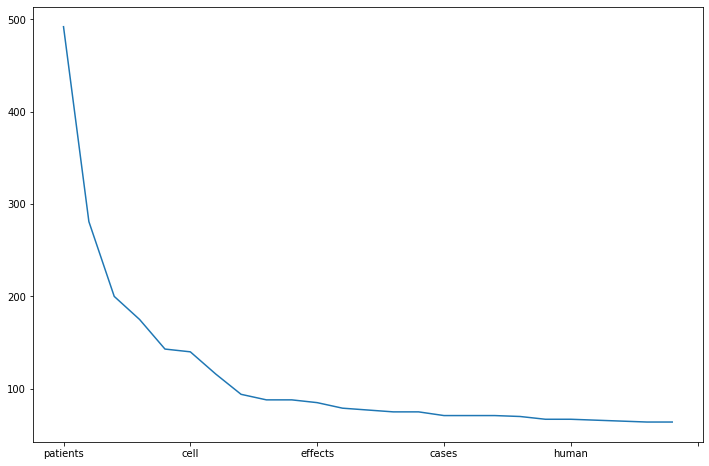

In [100]:
all_sentence_df[(all_sentence_df['pos'] == 'NOUN') | ((all_sentence_df['pos'] == 'PROPN'))]['word'].value_counts()[:25].plot(figsize=(12,8))
all_sentence_df[(all_sentence_df['pos'] == 'NOUN') | ((all_sentence_df['pos'] == 'PROPN'))]['word'].value_counts()[:25]

### Post EDA processing
#### Get detial view of **sentence **
Dataframe preparation

In [101]:
# Class to retrieve the sentences details from the dataframe
class sentencedetail(object):
    def __init__(self, data):
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, l) for w, p, l in zip(s["word"].values.tolist(), s["pos"].values.tolist(),s["label"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [108]:
# Fetch detail view of sentence for train set
train_sent_obj = sentencedetail(train_df)
train_sent_detail = train_sent_obj.sentences
# Sample value of a sentence  from trainset
train_sent_detail[1]

[('The', 'PRON', 'O'),
 ('total', 'NOUN', 'O'),
 ('cesarean', 'PROPN', 'O'),
 ('rate', 'NOUN', 'O'),
 ('was', 'AUX', 'O'),
 ('14.4', 'NUM', 'O'),
 ('%', 'INTJ', 'O'),
 ('(', 'PUNCT', 'O'),
 ('344', 'NUM', 'O'),
 ('of', 'ADP', 'O'),
 ('2395', 'NUM', 'O'),
 (')', 'PUNCT', 'O'),
 (',', 'PUNCT', 'O'),
 ('and', 'CCONJ', 'O'),
 ('the', 'PRON', 'O'),
 ('primary', 'NOUN', 'O'),
 ('rate', 'NOUN', 'O'),
 ('was', 'AUX', 'O'),
 ('11.4', 'NUM', 'O'),
 ('%', 'INTJ', 'O'),
 ('(', 'PUNCT', 'O'),
 ('244', 'NUM', 'O'),
 ('of', 'ADP', 'O'),
 ('2144', 'NUM', 'O'),
 (')', 'PUNCT', 'O')]

In [107]:
# Fetch detail view of sentence for test set
test_sent_obj = sentencedetail(test_df)
test_sent_detail = test_sent_obj.sentences
# Sample value of a sentence  from test set
test_sent_detail[1]

[('As', 'ADP', 'O'),
 ('the', 'PRON', 'O'),
 ('ambient', 'ADJ', 'O'),
 ('temperature', 'NOUN', 'O'),
 ('increases', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('there', 'ADV', 'O'),
 ('is', 'AUX', 'O'),
 ('an', 'PRON', 'O'),
 ('increase', 'VERB', 'O'),
 ('in', 'ADP', 'O'),
 ('insensible', 'ADJ', 'O'),
 ('fluid', 'NOUN', 'O'),
 ('loss', 'NOUN', 'O'),
 ('and', 'CCONJ', 'O'),
 ('the', 'PRON', 'O'),
 ('potential', 'ADJ', 'O'),
 ('for', 'ADP', 'O'),
 ('dehydration', 'NOUN', 'O')]

## Defining features for CRF





In [109]:
# Let's define the features to get the feature value for one word.
# Feature set
def word_to_features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[0]': word[0],
        'word[-1]': word[-1],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag':postag,
        'postag_isnounpronoun': postag in ['NOUN','PROPN'],
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word[0]': word1[0],
            '-1:word[-1]': word1[-1],
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            '-1:postag_isnounpronoun': postag1 in ['NOUN','PROPN']
        })
    else:
        features['BEG'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
            '+1:postag_isnounpronoun': postag1 in ['NOUN','PROPN']
        })
    else:
        features['END'] = True

    return features

## Getting the features

### Write a code/function to get the features for a sentence

In [110]:
# Write a code to get features for a sentence.
# Define a function to extract features for a sentence.
def sent_to_features(sent):
    return [word_to_features(sent, i) for i in range(len(sent))]

### Write a code/function to get the labels of a sentence

In [111]:
# Write a code to get the labels for a sentence.
def sent_to_labels(sent):
    return [label for token, postag, label in sent]

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [112]:
# Prepare X-train and X-test by extracting features from train and test dataset
X_train = [sent_to_features(s) for s in train_sent_detail]
X_test = [sent_to_features(s) for s in test_sent_detail]

### Define the labels as the target variable for test and the train dataset

In [113]:
# Prepare y-train and y-test by extracting labels from train and test dataset
y_train = [sent_to_labels(l) for l in train_sent_detail]
y_test = [sent_to_labels(l) for l in test_sent_detail]

## Build the CRF Model

In [116]:
# Build the CRF model.
try:
  crf = sklearn_crfsuite.CRF(max_iterations=200,c1=1.0, c2=0.01, all_possible_transitions=False)
except AttributeError:
    pass
# fit the model
crf.fit(X_train, y_train)

AttributeError: ignored

TypeError: ignored

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

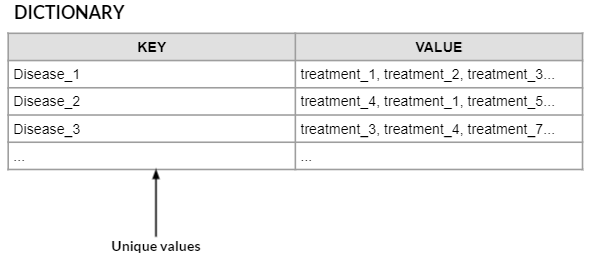

### Predict the treatment for the disease name: 'hereditary retinoblastoma'